In [1]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from transformers import pipeline
from tqdm.notebook import tqdm
import nltk
import random

In [9]:
nltk.download('stopwords')
plt.style.use('ggplot')
print("Loading dataset...")
df = pd.read_csv(
    'tweetts.csv',
    encoding='ISO-8859-1',
    names=['target', 'ids', 'date', 'flag', 'user', 'text'],
    header=None,
    on_bad_lines='skip'
)


Loading dataset...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SHUBHAM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# Keep only relevant columns
df = df[['text', 'target']].copy()

# Map sentiment labels (0 = negative, 4 = positive)
df['true_sentiment'] = df['target'].map({0: 'negative', 4: 'positive'})

# %% [4] Data Preprocessing
print("🧹 Cleaning tweets...")
stop_words = set(stopwords.words('english'))

🧹 Cleaning tweets...


In [11]:
def clean_tweet(tweet):
    # Remove URLs, mentions, and special chars
    tweet = re.sub(r"http\S+|@\w+|[^a-zA-Z\s']", " ", str(tweet))
    # Remove stopwords and short words
    tokens = [word.lower() for word in tweet.split() 
             if word.lower() not in stop_words and len(word) > 2]
    return " ".join(tokens).strip()

tqdm.pandas(desc="Cleaning progress")
df['clean_text'] = df['text'].progress_apply(clean_tweet)

Cleaning progress:   0%|          | 0/34982 [00:00<?, ?it/s]

In [12]:
print("Loading sentiment analyzer...")
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    framework="pt",  # Use PyTorch
    device=-1  # Use CPU (0 for GPU)
)


Loading sentiment analyzer...


Device set to use cpu


In [13]:
print(" Analyzing sentiment...")
def analyze_sentiment(text):
    try:
        if len(text) < 3:  # Skip empty/short texts
            return 'neutral', 0.0
        result = sentiment_analyzer(text[:512])[0]  # Truncate to 512 tokens
        return result['label'].lower(), result['score']
    except Exception as e:
        print(f"Error analyzing text: {str(e)}")
        return 'neutral', 0.0

tqdm.pandas(desc="Analysis progress")
df[['predicted_sentiment', 'confidence']] = df['clean_text'].progress_apply(
    lambda x: pd.Series(analyze_sentiment(x))
)


 Analyzing sentiment...


Analysis progress:   0%|          | 0/34982 [00:00<?, ?it/s]

 Generating visualizations...


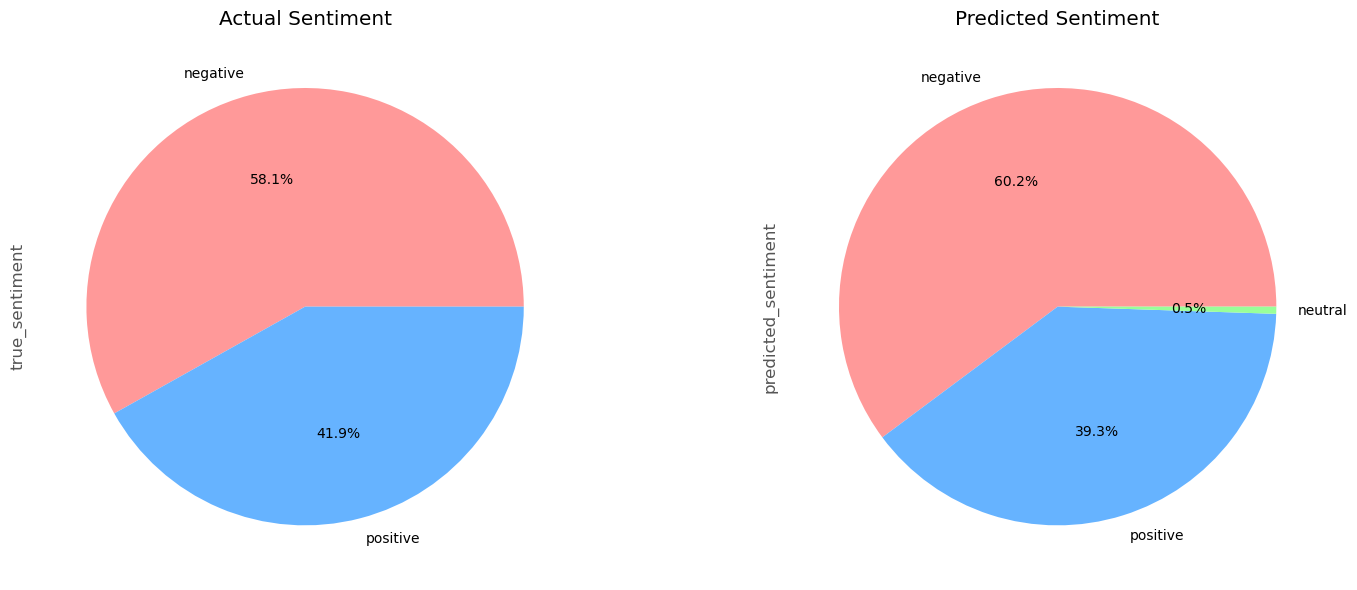

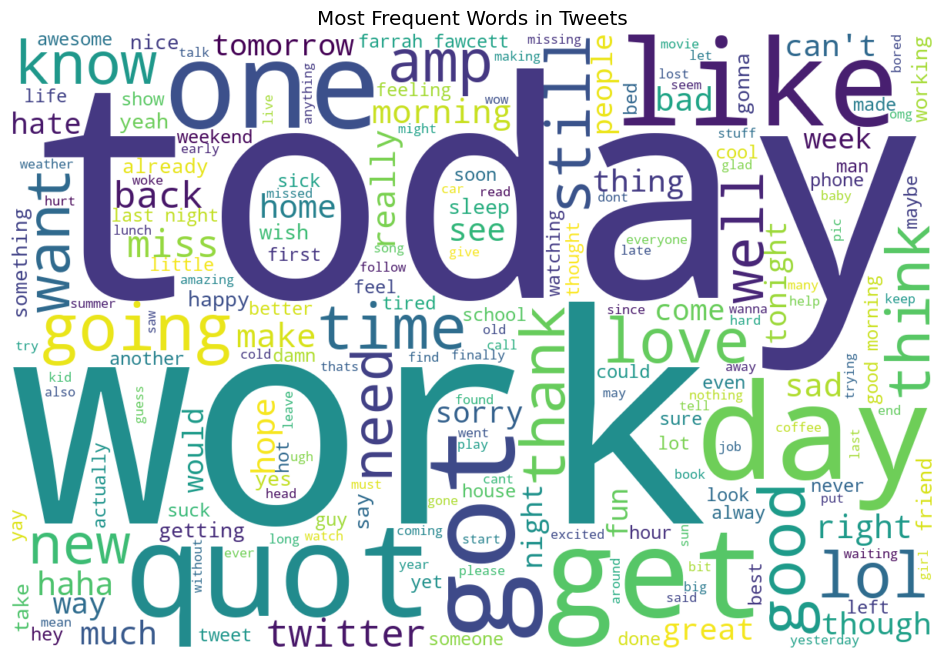

In [14]:
print(" Generating visualizations...")
# Sentiment Distribution
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
df['true_sentiment'].value_counts().plot(
    kind='pie', autopct='%1.1f%%', ax=ax[0], 
    colors=['#ff9999','#66b3ff'], title='Actual Sentiment'
)
df['predicted_sentiment'].value_counts().plot(
    kind='pie', autopct='%1.1f%%', ax=ax[1],
    colors=['#ff9999','#66b3ff','#99ff99'], title='Predicted Sentiment'
)
plt.tight_layout()
plt.show()

# Word Cloud
wordcloud = WordCloud(
    width=1200, height=800,
    background_color='white',
    stopwords=stop_words
).generate(" ".join(df['clean_text']))

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Words in Tweets")
plt.show()


In [15]:
df.to_csv('analyzed_tweets.csv', index=False)
print("Analysis complete! Results saved to analyzed_tweets.csv")

Analysis complete! Results saved to analyzed_tweets.csv


In [19]:
# %% [8] Evaluation & Saving
print("Saving results...")
from sklearn.metrics import classification_report

print("\nClassification Report:")
print(classification_report(
    df['true_sentiment'],
    df['predicted_sentiment'],
    labels=['positive', 'negative', 'neutral']
))


Saving results...

Classification Report:
              precision    recall  f1-score   support

    positive       0.63      0.59      0.61     14651
    negative       0.72      0.75      0.73     20331
     neutral       0.00      0.00      0.00         0

    accuracy                           0.68     34982
   macro avg       0.45      0.45      0.45     34982
weighted avg       0.68      0.68      0.68     34982



C:\Users\SHUBHAM\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SHUBHAM\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SHUBHAM\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
